# Building the prediction model for Random Forest

In V3, we are running a Random Forest classifier algorithm to access team, manager and stadium IDs in combination with recent form (last 5 games) data.

## imports

In [279]:
# imports
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

v3 = pd.read_csv('/Users/thomasdoherty/Desktop/football-project/football-project-mvp/prem_v3.csv')

# V3
- Stadium code added
- Manager code
- Team IDs
- More of the feature engineered columns to be looked at

In [280]:
v3.head()

,date,Venue,Gameweek / 38,home_team,Home Manager,Home GF,Away GF,away_team,Away Manager,Result,...,home_pts_last_5,away_ppg_season,away_pts_last_5,pts_last_5_diff,home_avg_rating,away_avg_rating,best_home_player_rating,best_away_player_rating,home_net_goals,away_net_goals
0,2008-08-17,Old Trafford,1,Manchester United,Sir Alex Ferguson,1,1,Newcastle United,Kevin Keegan,0,...,0,0.0,0,0,82.5,75.7,91.5,83.0,0.99,-0.37
1,2008-08-16,Emirates Stadium,1,Arsenal,Arsène Wenger,1,0,West Bromwich Albion,Tony Mowbray,1,...,0,0.0,0,0,75.8,70.4,85.0,77.5,0.83,-0.37
2,2008-08-16,Stadium of Light,1,Sunderland,Roy Keane,0,1,Liverpool,Rafael Benítez,-1,...,0,0.0,0,0,73.6,79.9,81.5,88.5,-0.35,0.64
3,2008-08-16,Upton Park,1,West Ham United,Alan Curbishley,2,1,Wigan Athletic,Steve Bruce,1,...,0,0.0,0,0,77.0,72.9,82.0,77.0,-0.21,-0.63
4,2008-08-17,Villa Park,1,Aston Villa,Martin O'Neill,4,2,Manchester City,Mark Hughes,1,...,0,0.0,0,0,76.6,70.0,83.0,80.5,-0.42,0.98


In [281]:
v3.columns

Index(['date', 'Venue', 'Gameweek / 38', 'home_team', 'Home Manager',
       'Home GF', 'Away GF', 'away_team', 'Away Manager', 'Result', 'Home Win',
       'p(Home)', 'p(Draw)', 'p(Away)', 'Margin', 'id', 'season', 'Home ID',
       'Away ID', 'Venue Code', 'Home Manager Code', 'Away Manager Code',
       'Day', 'Day Code', 'p(Home 3+ GF)', 'p(Home 3+ GA)', 'p(Away 3+ GF)',
       'p(Away 3+ GA)', 'home_team_ppg', 'away_team_ppg', 'home_ppg_season',
       'home_pts_last_5', 'away_ppg_season', 'away_pts_last_5',
       'pts_last_5_diff', 'home_avg_rating', 'away_avg_rating',
       'best_home_player_rating', 'best_away_player_rating', 'home_net_goals',
       'away_net_goals'],
      dtype='object')

We can drop the columns below but it may be easier to keep them for when we want to look at which results were predicted right and wrong.

In [110]:
# # Drop Venue, we have Venue Code
# v3.drop('Venue', axis=1, inplace=True)

# # Drop Home Manager and Away Manager, we have Manager Code
# v3.drop(['Home Manager', 'Away Manager'], axis=1, inplace=True)

# # Drop Day, we have day code
# v3.drop('Day', axis=1, inplace=True)

# # Drop Home Team and Away Team, we have team ID
# v3.drop(['home_team', 'away_team'], axis=1, inplace=True)

# # Drop season
# v3.drop('season', axis=1, inplace=True)

# # Drop Margin
# v3.drop('Margin', axis=1, inplace=True)

## Time Series Data

We are training our model on past matches, to be able to predict future ones, so training data should be dated before testing data. If we still aim for around 20-25% testing data then that gives us the last two seasons, which would begin around August 2014. This way:

- Our training data is six seasons 2008-09, 09-10, 10-11, 11-12, 12-13, 13-14
- Our testing data is two seasons 2014-15 and 2015-16

In [282]:
train = v3[v3['date'] < '2014-08-01']
test = v3[v3['date'] >= '2014-08-01']

In [283]:
# date ranges of train and test data
train['date'].min(), train['date'].max(), test['date'].min(), test['date'].max()

('2008-08-16', '2014-05-11', '2014-08-16', '2016-05-17')

Confirmed - the dates of the two training sets do not overlap

In [284]:
print(f"Training data has {train.shape[0]} records with {test.shape[1]} columns starting {train['date'].min()} and ending {train['date'].max()},\n"
      f"Testing data has {test.shape[0]} records with {test.shape[1]} columns starting {test['date'].min()} and ending {test['date'].max()}\n")
test.shape[0] / v3.shape[0]

Training data has 2280 records with 41 columns starting 2008-08-16 and ending 2014-05-11,
Testing data has 760 records with 41 columns starting 2014-08-16 and ending 2016-05-17



0.25

## Predictors for V3 - Training data

In [285]:
train.columns

Index(['date', 'Venue', 'Gameweek / 38', 'home_team', 'Home Manager',
       'Home GF', 'Away GF', 'away_team', 'Away Manager', 'Result', 'Home Win',
       'p(Home)', 'p(Draw)', 'p(Away)', 'Margin', 'id', 'season', 'Home ID',
       'Away ID', 'Venue Code', 'Home Manager Code', 'Away Manager Code',
       'Day', 'Day Code', 'p(Home 3+ GF)', 'p(Home 3+ GA)', 'p(Away 3+ GF)',
       'p(Away 3+ GA)', 'home_team_ppg', 'away_team_ppg', 'home_ppg_season',
       'home_pts_last_5', 'away_ppg_season', 'away_pts_last_5',
       'pts_last_5_diff', 'home_avg_rating', 'away_avg_rating',
       'best_home_player_rating', 'best_away_player_rating', 'home_net_goals',
       'away_net_goals'],
      dtype='object')

Let's use the venue & manager code, in addition to the recent form points in the last 5

Scaling isn't necessary because of the threshold based interpretation of the Random Forest algorithm.

In [286]:
# feature column dropping non-numeric and target columns
features = train.columns.drop(['Home Win', 'date', 'Venue', 'Gameweek / 38', 'home_team', 'Home Manager', 'Home GF', 'Away GF', 'Away Manager', 'id', 'away_team', 'season', 'Result', 'Margin', 'Day', 'home_team_ppg', 'away_team_ppg'])


# features = ['Venue Code', 'Home ID', 'Away ID', 'Home Manager Code', 'Away Manager Code', 'home_pts_last_5', 'away_pts_last_5', 'home_ppg_season', 'away_ppg_season', 'home_avg_rating', 'away_avg_rating', 'Day Code']
target = ['Home Win']

In [287]:
features

Index(['p(Home)', 'p(Draw)', 'p(Away)', 'Home ID', 'Away ID', 'Venue Code',
       'Home Manager Code', 'Away Manager Code', 'Day Code', 'p(Home 3+ GF)',
       'p(Home 3+ GA)', 'p(Away 3+ GF)', 'p(Away 3+ GA)', 'home_ppg_season',
       'home_pts_last_5', 'away_ppg_season', 'away_pts_last_5',
       'pts_last_5_diff', 'home_avg_rating', 'away_avg_rating',
       'best_home_player_rating', 'best_away_player_rating', 'home_net_goals',
       'away_net_goals'],
      dtype='object')

## Training the Model - Predicting a home win or not

In [288]:
rf = RandomForestClassifier(
    n_estimators=100, 
    min_samples_split=10, # the number of records before we split a node - e.g. a specific stadium / manager,
    random_state=42)

rf.fit(train[features], train[target])

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(min_samples_split=10, random_state=42)

### Predictions & Evaluation

In [289]:
preds = rf.predict(test[features])

In [290]:
# Accuracy score
print(accuracy_score(test[target], preds))

# classification report
print(classification_report(test[target], preds))

0.6342105263157894
              precision    recall  f1-score   support

           0       0.66      0.73      0.69       431
           1       0.59      0.51      0.55       329

    accuracy                           0.63       760
   macro avg       0.63      0.62      0.62       760
weighted avg       0.63      0.63      0.63       760



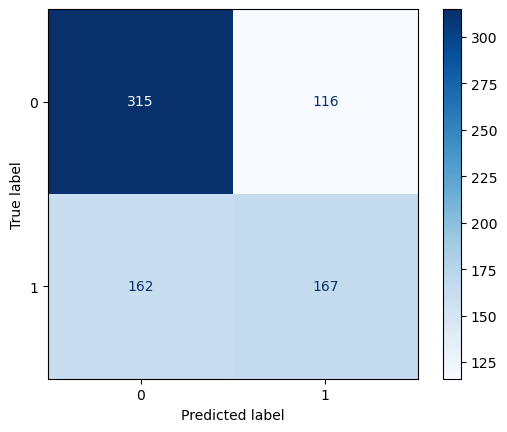

In [291]:
# confusion Matrix
cm = confusion_matrix(test[target], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)

These are not bad results. They are relatively balanced in precision/recall but interesting that recall is worse for predicting home wins than for not home wins. IN previous runs, recall was excellent for home wins but poor for draw and away wins, I expect it's flipped now because the home win result is now the minority outcome when away and draw are combined into one. So now the prior probability bias is with the opposite class.

The Precision/Recall score is balanced nicely despite a slight class imbalance of more Draws or Away wins than Home wins.

### Cross-validation 

In [150]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(rf, X, y, cv=5, scoring='accuracy')
print("Cross-validation scores:", scores)
print("Mean accuracy:", scores.mean())


NameError: name 'X' is not defined

## Predicting Home Win/ Draw / Away Win

Now predicting a Home, draw or Away win

In [325]:
features = train.columns.drop(['Home Win', 'date', 'Venue', 'Gameweek / 38', 'home_team', 'Home Manager', 'Home GF', 'Away GF', 'Away Manager', 'id', 'away_team', 
                               'season', 'Result', 'Margin', 'Day', 'home_team_ppg', 'away_team_ppg', 'home_net_goals', 'away_net_goals'])

# features = ['Venue Code', 'Home ID', 'Away ID', 'Home Manager Code', 'Away Manager Code', 'home_pts_last_5', 'away_pts_last_5', 'home_ppg_season', 'away_ppg_season', 'home_avg_rating', 'away_avg_rating', 'Day Code']
target = ['Result']

In [305]:
# use the base rates found - define them inversely proportional to frequency
class_weights = {0: 1 / 0.258, 
                 1: 1 / 0.285, 
                 -1: 1 / 0.457}  # Adjust these based on base rates

In [329]:
rf = RandomForestClassifier(
    max_depth=10,
    n_estimators=500, 
    min_samples_split=10, # the number of records before we split a node - e.g. a specific stadium / manager,
    min_samples_leaf=2,
    max_features='sqrt',
    # class_weight=class_weights,
    random_state=42)

# Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
# Best Cross-Validation Accuracy: 0.5403508771929825

rf.fit(train[features], train[target])

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=10,
                       n_estimators=500, random_state=42)

In [330]:
preds_wdl = rf.predict(test[features])

### Home/Draw/Away - Model Evaluation

In [331]:
# Accuracy score
print(accuracy_score(test[target], preds_wdl))

# classification report
print(classification_report(test[target], preds_wdl))

0.49473684210526314
              precision    recall  f1-score   support

          -1       0.49      0.49      0.49       231
           0       0.16      0.03      0.04       200
           1       0.52      0.78      0.62       329

    accuracy                           0.49       760
   macro avg       0.39      0.43      0.39       760
weighted avg       0.42      0.49      0.43       760



You can even see in the testing portion here the breakdown of result frequencies mirrors that of the prior probabilities we saw in EDA

-1 (Away win) was 231 / 760 = 30.4%
0 (Draw) was 200 / 760 = 26.3%
1 (Home win) was 329 / 43.2%

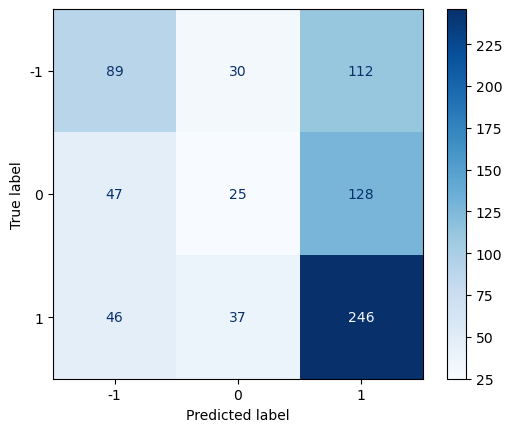

In [309]:
# confusion matrix 
cm = confusion_matrix(test[target], preds_wdl)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)

These are poorer than the 52% I was looking at in V2 but we have now stopped any data leakage and draw predictions are coming through, even though they are worse than chance. We still have the home prediction bias from before.

Our testing data has 760 results, and we can see that there were 43.2% home wins, 26.3% draws and 30% away wins so we are still very close to those prior probabilities.

We can leverage the base rates we found with Bayesian priors as the *starting point* and with threshold tuning

In [310]:
# feature importance

importances = rf.feature_importances_
feature_names = v3[features].columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(importance_df.sort_values(by='Importance', ascending=False))

                    Feature  Importance
19          away_avg_rating    0.080419
13          home_ppg_season    0.078681
18          home_avg_rating    0.076075
15          away_ppg_season    0.075013
20  best_home_player_rating    0.063586
9             p(Home 3+ GF)    0.061271
21  best_away_player_rating    0.058126
11            p(Away 3+ GF)    0.052984
17          pts_last_5_diff    0.047907
6         Home Manager Code    0.047498
16          away_pts_last_5    0.046118
10            p(Home 3+ GA)    0.045954
14          home_pts_last_5    0.045804
12            p(Away 3+ GA)    0.045724
7         Away Manager Code    0.044137
4                   Away ID    0.038108
3                   Home ID    0.035208
5                Venue Code    0.031913
8                  Day Code    0.025475
1                   p(Draw)    0.000000
2                   p(Away)    0.000000
0                   p(Home)    0.000000


We can see the Away points average so far is more important as a feature (albeit just slightly) than the home manager, perhaps this is assessing whether the prior probability of a home win outcome is nullified.

#### Cross-validation:

In [324]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Initialize the Random Forest model
rf = RandomForestClassifier(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', verbose=0, n_jobs=-1)
grid_search.fit(train[features], train[target])

# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,),

Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}
Best Cross-Validation Accuracy: 0.5403508771929825


Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 500}

Best Cross-Validation Accuracy: 0.5403508771929825

#### Example Tree Paths
- it's still a black box but you can see the main conditions around recent form and some Manager IDs

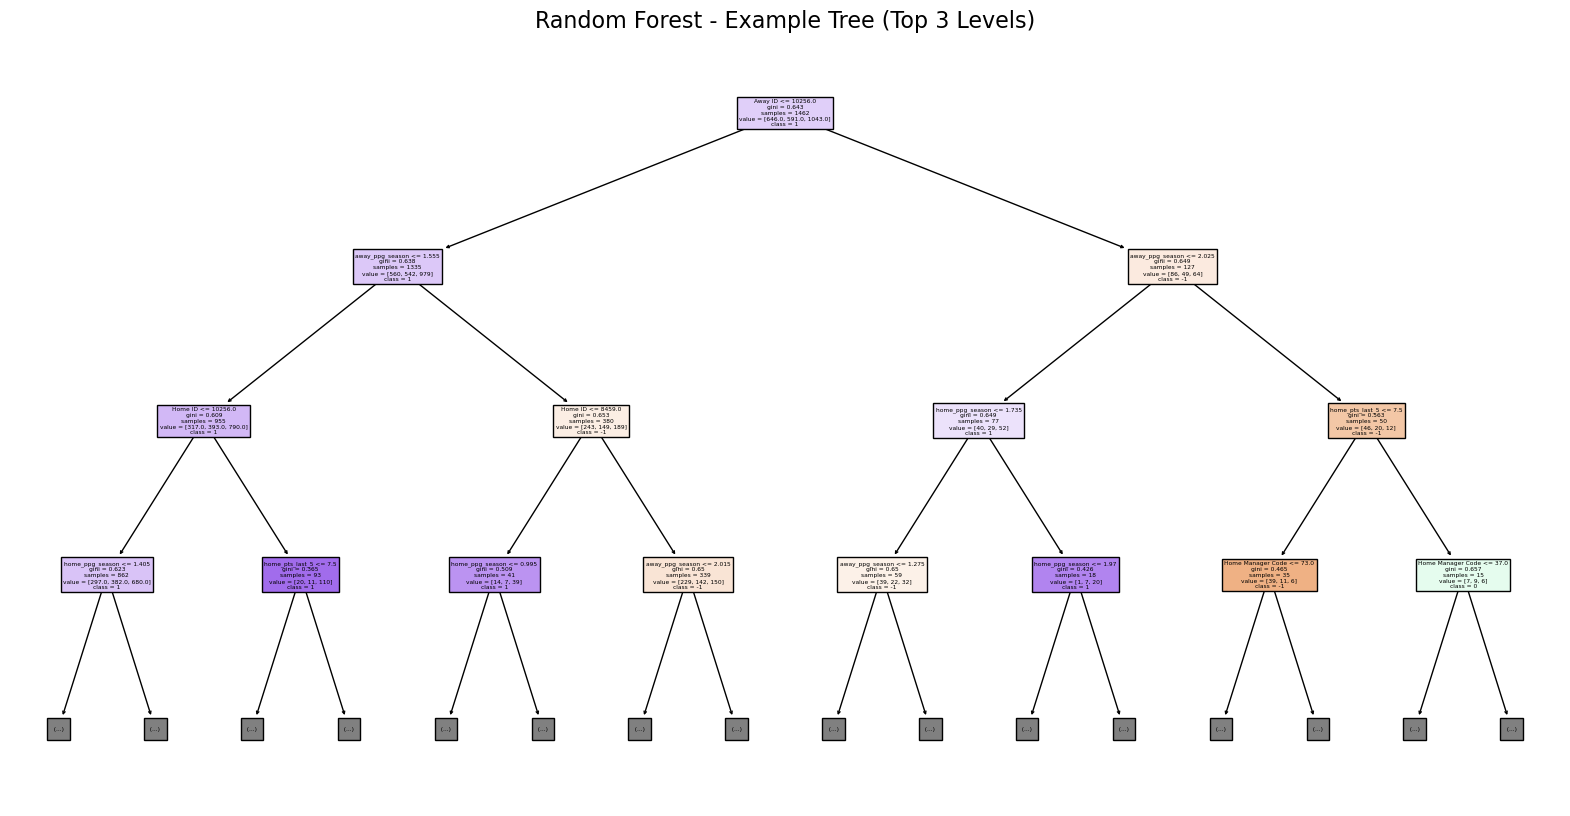

In [97]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Visualize one tree with a limited depth
plt.figure(figsize=(20, 10))
plot_tree(
    rf.estimators_[0],  # Select one tree from the Random Forest
    feature_names=features,  # Replace with your feature names
    class_names=['-1', '0', '1'],  # Replace with your class names
    filled=True,
    max_depth=3  # Display only the top 3 levels
)
plt.title("Random Forest - Example Tree (Top 3 Levels)", fontsize=16)
plt.show()

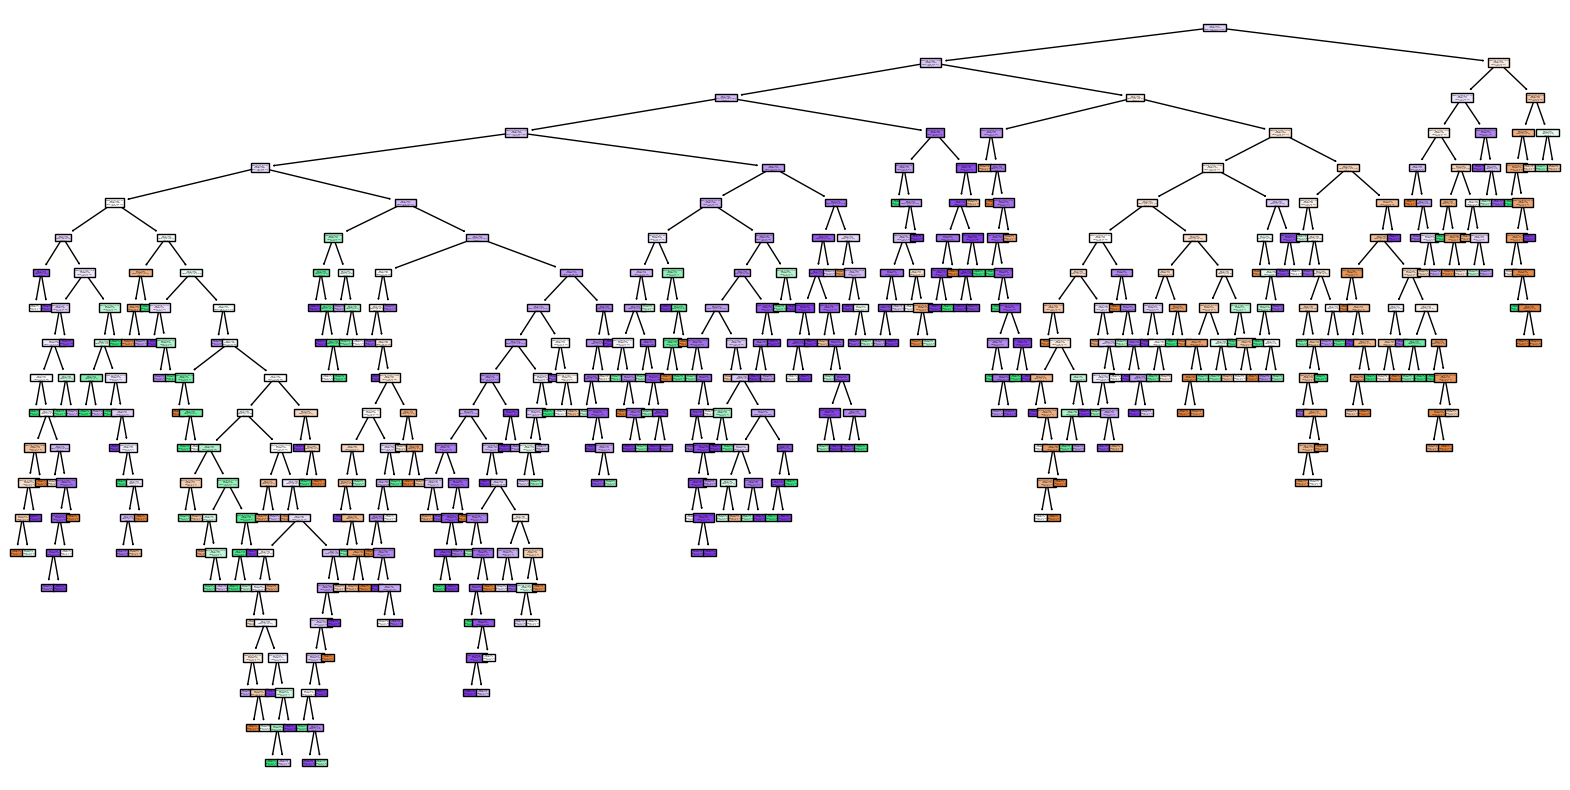

In [98]:
from sklearn.tree import plot_tree

# Visualize one tree in the forest
plt.figure(figsize=(20, 10))
plot_tree(rf.estimators_[0], feature_names=features, class_names=['-1', '0', '1'], filled=True)
plt.show()

### Combine predictions with the test set

In [99]:
test.index

Index([2280, 2281, 2282, 2283, 2284, 2285, 2286, 2287, 2288, 2289,
       ...
       3030, 3031, 3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039],
      dtype='int64', length=760)

In [100]:
v3.index

RangeIndex(start=0, stop=3040, step=1)

In [314]:
# Ensure target column is 1-dimensional
actual_results = test[target].squeeze()  # Converts (760, 1) to (760,) if needed

# Create a DataFrame for predictions and actual results
results_df = pd.DataFrame({
    'Actual Result': actual_results,  # Ensure this is 1D
    'Predicted Result': preds_wdl.squeeze()  # Ensure predictions are 1D
}, index=test.index)  # Retain the same index as the test set

# Extract human-readable columns using test.index from v3
original_columns = ['date', 'Venue', 'home_team', 'Home GF', 'Away GF', 'away_team', 'Home Manager', 'Away Manager', 'home_pts_last_5', 'away_pts_last_5', 'Day']
readable_columns = v3.loc[test.index, original_columns]

# Combine readable columns and prediction results
results_with_details = pd.concat([results_df, readable_columns], axis=1)

# Display the results DataFrame
results_with_details.sample(10)

,Actual Result,Predicted Result,date,Venue,home_team,Home GF,Away GF,away_team,Home Manager,Away Manager,home_pts_last_5,away_pts_last_5,Day
2683,1,1,2015-10-31,Etihad Stadium,Manchester City,2,1,Norwich City,Manuel Pellegrini,Alex Neil,7,2,Saturday
2800,0,-1,2016-01-16,Villa Park,Aston Villa,1,1,Leicester City,Rémi Garde,Claudio Ranieri,5,8,Saturday
2803,-1,1,2016-01-17,Anfield,Liverpool,0,1,Manchester United,Jürgen Klopp,Louis van Gaal,7,5,Sunday
2508,-1,1,2014-08-31,White Hart Lane,Tottenham Hotspur,0,3,Liverpool,Mauricio Pochettino,Brendan Rodgers,6,3,Sunday
2528,1,1,2015-04-04,Swansea.com Stadium,Swansea City,3,1,Hull City,Garry Monk,Steve Bruce,9,5,Saturday
2639,1,1,2014-10-05,Upton Park,West Ham United,2,0,Queens Park Rangers,Sam Allardyce,Harry Redknapp,7,4,Sunday
2414,0,1,2015-01-10,Goodison Park,Everton,1,1,Manchester City,Roberto Martínez,Manuel Pellegrini,3,13,Saturday
2459,-1,0,2015-02-10,Stadium of Light,Sunderland,0,2,Queens Park Rangers,Gus Poyet,Chris Ramsey,4,1,Tuesday
2715,1,1,2015-11-28,Etihad Stadium,Manchester City,3,1,Southampton,Manuel Pellegrini,Ronald Koeman,8,8,Saturday
2675,0,1,2015-10-25,Old Trafford,Manchester United,0,0,Manchester City,Louis van Gaal,Manuel Pellegrini,12,9,Sunday


From the sample here, the predictions both correct and incorrect are quite plausible, 2414 Everton vs Man City is questionable, predicting an Everton win against in-form Man City. Otherwise, none of these sample records look like ridiculous mistakes.

### Results we missed

- Which results did we mis-predict?

In [315]:
# saving to csv
results_with_details.to_csv('/Users/thomasdoherty/Desktop/football-project/football-project-mvp/v3_results_details.csv', index=False)

In [317]:
# which results were predicted incorrectly
incorrect = results_with_details[results_with_details['Actual Result'] != results_with_details['Predicted Result']]

print(incorrect.shape)

incorrect.sample(20)

(400, 13)


,Actual Result,Predicted Result,date,Venue,home_team,Home GF,Away GF,away_team,Home Manager,Away Manager,home_pts_last_5,away_pts_last_5,Day
2299,0,1,2014-11-01,bet365 Stadium,Stoke City,2,2,West Ham United,Mark Hughes,Sam Allardyce,7,12,Saturday
2436,-1,1,2015-02-01,St Mary's Stadium,Southampton,0,1,Swansea City,Ronald Koeman,Garry Monk,13,5,Sunday
2293,-1,1,2014-11-03,Selhurst Park,Crystal Palace,1,3,Sunderland,Neil Warnock,Gus Poyet,7,5,Monday
3023,-1,1,2015-10-03,Stamford Bridge,Chelsea,1,3,Southampton,José Mourinho,Ronald Koeman,7,8,Saturday
3025,0,1,2015-10-04,Goodison Park,Everton,1,1,Liverpool,Roberto Martínez,Brendan Rodgers,8,5,Sunday
3032,-1,0,2015-10-17,Goodison Park,Everton,0,3,Manchester United,Roberto Martínez,Louis van Gaal,9,9,Saturday
2691,0,-1,2015-11-08,Villa Park,Aston Villa,0,0,Manchester City,Rémi Garde,Manuel Pellegrini,0,10,Sunday
2422,0,1,2015-01-19,Goodison Park,Everton,0,0,West Bromwich Albion,Roberto Martínez,Tony Pulis,1,4,Monday
2560,1,0,2015-05-02,Villa Park,Aston Villa,3,2,Everton,Tim Sherwood,Roberto Martínez,4,13,Saturday
2819,0,-1,2016-01-23,Upton Park,West Ham United,2,2,Manchester City,Slaven Bilić,Manuel Pellegrini,10,11,Saturday


### Results we missed

Which results did we get wrong here? From the confusion matrix, it would be likely misclassifying other away wins or draws as Home wins

Looking at the above:

#### Were some stadiums / venues harder to predict the match than others?

In [318]:
# for the test data get a value count of every venue and the number of games played there
test['Venue'].value_counts()

Venue
Emirates Stadium       38
Villa Park             38
White Hart Lane        38
Swansea.com Stadium    38
Stadium of Light       38
St Mary's Stadium      38
Etihad Stadium         38
Goodison Park          38
Selhurst Park          38
Stamford Bridge        38
Upton Park             38
The Hawthorns          38
bet365 Stadium         38
St James' Park         38
Old Trafford           38
Anfield                38
King Power Stadium     38
Turf Moor              19
MKM Stadium            19
Loftus Road            19
Vitality Stadium       19
Carrow Road            19
Vicarage Road          19
Name: count, dtype: int64

In [319]:
print(incorrect['Venue'].value_counts())

Venue
bet365 Stadium         26
Selhurst Park          25
Stadium of Light       25
St James' Park         24
Villa Park             24
Upton Park             22
The Hawthorns          22
Goodison Park          22
Swansea.com Stadium    20
Anfield                20
Stamford Bridge        18
St Mary's Stadium      18
King Power Stadium     18
White Hart Lane        16
Emirates Stadium       14
MKM Stadium            14
Old Trafford           12
Etihad Stadium         12
Turf Moor              10
Loftus Road            10
Vitality Stadium       10
Carrow Road             9
Vicarage Road           9
Name: count, dtype: int64


In [336]:
# Count incorrect predictions by venue
incorrect_predictions = incorrect['Venue'].value_counts()

# Count total matches by venue
total_matches = test['Venue'].value_counts()

# Create a mapping of venue to home teams from the `incorrect` DataFrame
venue_to_home_team = incorrect.groupby('Venue')['home_team'].first()

# Combine total matches and incorrect predictions using merge
venue_stats = pd.merge(
    total_matches.rename('Total Matches'), 
    incorrect_predictions.rename('Incorrect Predictions'), 
    left_index=True, 
    right_index=True, 
    how='left'
).fillna(0)  # Fill NaN values with 0 for venues without incorrect predictions

# Add the home_team column by mapping from `venue_to_home_team`
venue_stats['Home Team'] = venue_stats.index.map(venue_to_home_team)

# Convert to integers for clarity
venue_stats['Incorrect Predictions'] = venue_stats['Incorrect Predictions'].astype(int)
venue_stats['Total Matches'] = venue_stats['Total Matches'].astype(int)

# Calculate Incorrect %
venue_stats['Incorrect %'] = round((venue_stats['Incorrect Predictions'] / venue_stats['Total Matches']) * 100, 1)

# Reset the index for better readability
venue_stats.reset_index(inplace=True)
venue_stats.rename(columns={'index': 'Venue'}, inplace=True)

# Reorder columns to place Home Team next to Venue
venue_stats = venue_stats[['Venue', 'Home Team', 'Total Matches', 'Incorrect Predictions', 'Incorrect %']]

# Display the DataFrame
venue_stats.sort_values(by='Incorrect %', inplace=True)
venue_stats


,Venue,Home Team,Total Matches,Incorrect Predictions,Incorrect %
14,Old Trafford,Manchester United,38,12,31.6
6,Etihad Stadium,Manchester City,38,12,31.6
0,Emirates Stadium,Arsenal,38,14,36.8
2,White Hart Lane,Tottenham Hotspur,38,16,42.1
16,King Power Stadium,Leicester City,38,18,47.4
21,Carrow Road,Norwich City,19,9,47.4
9,Stamford Bridge,Chelsea,38,18,47.4
22,Vicarage Road,Watford,19,9,47.4
5,St Mary's Stadium,Southampton,38,18,47.4
3,Swansea.com Stadium,Swansea City,38,20,52.6


In [321]:
print(sum(venue_stats['Incorrect Predictions']), 'of', sum(venue_stats['Total Matches']), 'predictions were incorrect')

400 of 760 predictions were incorrect


In [322]:
# and which ones we got right?
correct = results_with_details[results_with_details['Actual Result'] == results_with_details['Predicted Result']]

correct

,Actual Result,Predicted Result,date,Venue,home_team,Home GF,Away GF,away_team,Home Manager,Away Manager,home_pts_last_5,away_pts_last_5,Day
2280,1,1,2014-08-16,Emirates Stadium,Arsenal,2,1,Crystal Palace,Arsène Wenger,Tony Pulis,0,0,Saturday
2281,-1,-1,2014-08-18,Turf Moor,Burnley,1,3,Chelsea,Sean Dyche,José Mourinho,0,0,Monday
2283,1,1,2014-08-17,Anfield,Liverpool,2,1,Southampton,Brendan Rodgers,Ronald Koeman,0,0,Sunday
2289,-1,-1,2014-08-16,Upton Park,West Ham United,0,1,Tottenham Hotspur,Sam Allardyce,Mauricio Pochettino,0,0,Saturday
2290,1,1,2014-11-01,Emirates Stadium,Arsenal,3,0,Burnley,Arsène Wenger,Sean Dyche,8,2,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3027,-1,-1,2015-10-03,Carrow Road,Norwich City,1,2,Leicester City,Alex Neil,Claudio Ranieri,6,6,Saturday
3030,1,1,2015-10-17,Stamford Bridge,Chelsea,2,0,Aston Villa,José Mourinho,Tim Sherwood,4,1,Saturday
3033,1,1,2015-10-17,Etihad Stadium,Manchester City,5,1,Bournemouth,Manuel Pellegrini,Eddie Howe,9,5,Saturday
3034,1,1,2015-10-18,St James' Park,Newcastle United,6,2,Norwich City,Steve McClaren,Alex Neil,1,5,Sunday


## V2

In [ ]:
df.sample(5)

,PC1,PC2,PC3,PC4,p(Home),p(Draw),p(Away),Result
2964,0.005641,-0.282010,-1.129980,0.930118,0.457,0.258,0.285,1
1895,-0.403886,0.500769,-0.961058,-0.194123,0.457,0.258,0.285,1
2657,-0.857472,-0.891843,-0.075507,0.028527,0.457,0.258,0.285,-1
1584,-2.036530,0.256216,-0.330386,-0.645570,0.457,0.258,0.285,1
1453,-2.132244,1.370095,-1.306988,1.773362,0.457,0.258,0.285,1


### Train the model

In [ ]:
# Step 1: Split data into features (X) and target (y)
X_pca = df.drop('Result', axis=1)
y_pca = df['Result']

In [ ]:
# Step 2: Train-test split
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y_pca, test_size=0.2, random_state=42)

In [ ]:
# Step 3: Train Random Forest Classifier
rf_model = RandomForestClassifier(
    random_state=42, 
    n_estimators=100,  # Number of trees
    max_depth=5,       # Limit depth of each tree (same as decision tree for comparability)
    n_jobs=-1          # Use all available CPU cores for training
)
rf_model.fit(X_train_pca, y_train_pca)

RandomForestClassifier(max_depth=5, n_jobs=-1, random_state=42)

In [ ]:
# Step 4: Evaluate the Random Forest Model
y_pred_pca_rf = rf_model.predict(X_test_pca)

In [ ]:
# Accuracy and classification report
print("PCA Run Random Forest:")
print("Accuracy:", accuracy_score(y_test_pca, y_pred_pca_rf))
print(classification_report(y_test_pca, y_pred_pca_rf))

PCA Run Random Forest:
Accuracy: 0.5164473684210527
              precision    recall  f1-score   support

          -1       0.49      0.49      0.49       177
           0       0.60      0.02      0.04       152
           1       0.53      0.80      0.64       279

    accuracy                           0.52       608
   macro avg       0.54      0.44      0.39       608
weighted avg       0.53      0.52      0.44       608



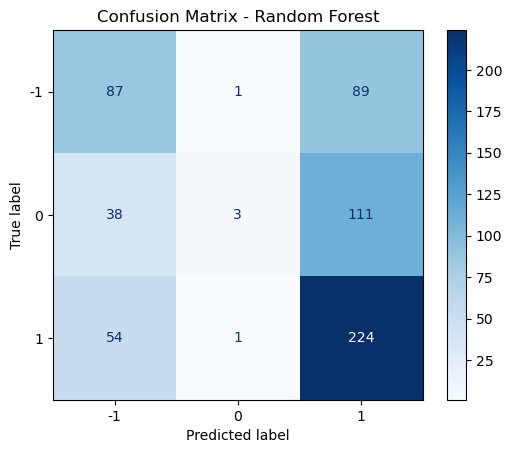

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test_pca, y_pred_pca_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=rf_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest")
plt.show()

In [ ]:
# print the cm
print(cm_pca_tree)

[[194   9  76]
 [ 79   5  68]
 [ 69   1 107]]


## Initial analysis

V2

__________


V1

With chance being 0.33, the initial performance of 50.33% is slightly worse than the logistic regression but its performance differs in that:
- It is slightly stronger in predicting away wins
- It is slightly weaker in predicting home wins
- It is willing to bet on draws occurring

The recall scores being higher than the precision scores shows that we will get a lot of false positives for the home win or away win.

However...**it is struggling with draws**

### V2 Feature importance


In [ ]:
importances = rf_model.feature_importances_
feature_names = X_pca.columns
for feature, importance in zip(feature_names, importances):
    print(f"{feature}: {importance:.4f}")

PC1: 0.1748
PC2: 0.5453
PC3: 0.1287
PC4: 0.1511
p(Home): 0.0000
p(Draw): 0.0000
p(Away): 0.0000


PC2 is clearly the most important feature contributing to predictions here, From the loadings in the previous workbook, this is the PC most related to differences between the home and away team.

PC1 has a lot of variance too and it is the next most important feature but less than 1/3 as important as PC2.